In [21]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2025 Alliance for Energy Innovation, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__deprecated__ = False

# Optimization routines and surrogate updates

This example shows how to run the optimization routines in `soogo` and visualize the updated surrogate model. We use two-dimensional problems to be able to visualize the progress.

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(
        FX,
        cmap="jet",
        extent=[bounds[0][0], bounds[0][1], bounds[1][1], bounds[1][0]],
    )
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(x[0 : len(x) - 1], y[0 : len(x) - 1], c="gray", marker="x")
    ax.scatter(x[-1], y[-1], c="w", marker="x")
    return fig, ax

The optimization uses one of the three objective functions:

1. `ackley()`: Many local minima, single global minimum. Global minimum is significantly smaller than local minima relative to the output range.
2. `eggholder()`: Many local minima, single global minimum. Global minimum and local minima are similar relative to the output range.
3. `quadratic()`: Convex problem, i.e., single minimum point. The objective function graph is almost flat.

The global minimum in the Ackley function is achieved in the origin (0,0) in the center of the domain. Some methods start sampling at the center of the domain. Thus, to make a fair comparison, we shift the minimum so no method have this initial advantage.

In [23]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2 * pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1] + 47) * np.sin(np.sqrt(abs(x[1] + 0.5 * x[0] + 47))) - x[
        0
    ] * np.sin(np.sqrt(abs(x[0] - (x[1] + 47))))


def quadratic(x):
    return (x[0] - 500) ** 2 + (x[1] - 2875) ** 2


objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder
objf["quadratic"] = quadratic

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]
refbounds["quadratic"] = [0, 10000]

Choose the objective function by changing the variable below:

In [24]:
# Define problem, dimensions and bounds
n = 2
funcstr = "ackley"


def func(x):
    return [objf[funcstr](xi) for xi in x]


bounds = [refbounds[funcstr]] * n

We define below the grid used for plotting the surrogate model at each step.

In [25]:
# Grid for plotting
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

To better visualize the intermediate steps of each optimizer, we define callback functions, which are called after each optimization step.

In [26]:
import soogo
from soogo import GaussianProcess, RbfModel, MedianLpfFilter, OptimizeResult
from soogo.utils import gp_expected_improvement


def callback_rbf(res: OptimizeResult, T: int = 10, savefig: bool = False):
    """
    Callback for an optimizer that uses the RBF surrogate.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """

    print("Best value of ", res.fx, " at ", res.x)
    print("Last sample point at ", res.sample[res.nfev - 1])

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        # Train model
        model = RbfModel()
        model.reserve(0, n)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        # Evaluate points in the grid
        S = np.zeros((ny, nx))
        for i in range(ny):
            S[i, :] = model(XY[i, :])

        # Plot figure
        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            S,
            bounds,
            "s(x,y)",
        )
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()


def callback_cptv(res: OptimizeResult, savefig: bool = False):
    """
    Callback for the CPTV optimizer.

    Use period for plotting equals to 1 to plot every time the method exits a
    CP or TV step.
    """
    callback_rbf(res, 1, savefig)


def callback_rbf_muMeas(
    res: OptimizeResult, T: int = 10, savefig: bool = False
):
    """
    Callback for an optimizer that uses the RBF surrogate and show the mu
    measurement.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """
    callback_rbf(res, T, savefig)

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        model = RbfModel(filter=MedianLpfFilter())
        model.reserve(0, n)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        model.prepare_mu_measure()
        MuMeas = np.zeros((ny, nx))
        for i in range(ny):
            MuMeas[i, :] = model.mu_measure(XY[i, :])

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            np.log(MuMeas),
            bounds,
            "log(muMeas(x,y))",
        )
        if savefig:
            plt.savefig("logMuMeas_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()


def callback_gp(res: OptimizeResult, T: int = 10, savefig: bool = False):
    """
    Callback for an optimizer that uses the GP surrogate.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """

    print("Best value of ", res.fx, " at ", res.x)
    print("Last sample point at ", res.sample[res.nfev - 1])

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        model = GaussianProcess(n_restarts_optimizer=20, normalize_y=True)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        Mean = np.zeros((ny, nx))
        Std = np.zeros((ny, nx))
        EI = np.zeros((ny, nx))
        for i in range(ny):
            Mean[i, :], Std[i, :] = model(XY[i, :], return_std=True)
            EI[i, :] = gp_expected_improvement(res.fx - Mean[i, :], Std[i, :])

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            Mean,
            bounds,
            "s(x,y)",
        )
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            Std,
            bounds,
            "std(x,y)",
        )
        if savefig:
            plt.savefig("std_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            EI,
            bounds,
            "EI(x,y)",
        )
        if savefig:
            plt.savefig("EI_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

Choose an optimizer and the corresponding callback function. Examples given in comments below:

Best value of  16.64032536125468  at  [-7.12846931  1.09708461]
Last sample point at  [-7.12846931  1.09708461]
Best value of  16.64032536125468  at  [-7.12846931  1.09708461]
Last sample point at  [-7.68010071 31.92765883]
Best value of  16.64032536125468  at  [-7.12846931  1.09708461]
Last sample point at  [ 2.30054057 15.08020973]
Best value of  13.065046544326734  at  [-0.51085492  7.43785654]
Last sample point at  [-0.51085492  7.43785654]
Best value of  10.150482448718755  at  [0.46950173 5.98993053]
Last sample point at  [0.46950173 5.98993053]


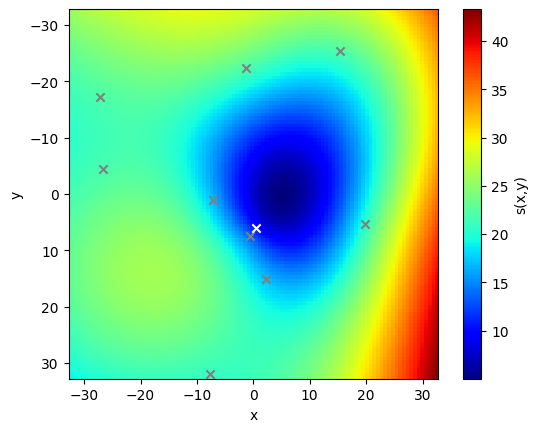

Best value of  10.150482448718755  at  [0.46950173 5.98993053]
Last sample point at  [-27.56470053  17.13282072]
Best value of  10.150482448718755  at  [0.46950173 5.98993053]
Last sample point at  [ 8.82766477 -8.85076801]
Best value of  6.305296789838373  at  [4.73846939 2.13748896]
Last sample point at  [4.73846939 2.13748896]
Best value of  5.876645068004471  at  [4.56307306 3.43560836]
Last sample point at  [4.56307306 3.43560836]
Best value of  5.876645068004471  at  [4.56307306 3.43560836]
Last sample point at  [22.97475367 27.02209018]
Best value of  5.876645068004471  at  [4.56307306 3.43560836]
Last sample point at  [11.81696646  7.08040689]
Best value of  5.876645068004471  at  [4.56307306 3.43560836]
Last sample point at  [3.61145499 4.67580923]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [3.02456987 3.44013091]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [-15.57169353 -30.45252175]
Best value o

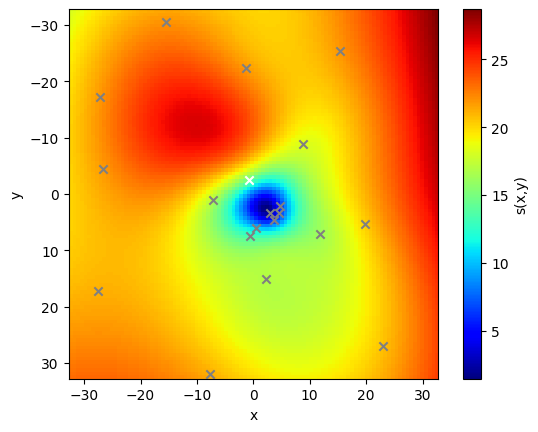

Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [3.26936971 2.05852412]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [2.76496702 4.23982982]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [ 26.67067362 -11.95584045]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [12.27843161 17.5263691 ]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [1.93395997 1.60688996]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [3.20388325 2.5961379 ]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [-7.39326159 16.46951691]
Best value of  2.362272211969206  at  [3.02456987 3.44013091]
Last sample point at  [3.6034427  0.61157897]
Best value of  1.7490953457131266  at  [3.34169655 3.26972961]
Last sample point at  [3.34169655 3.26972961]
Best value of  1.74

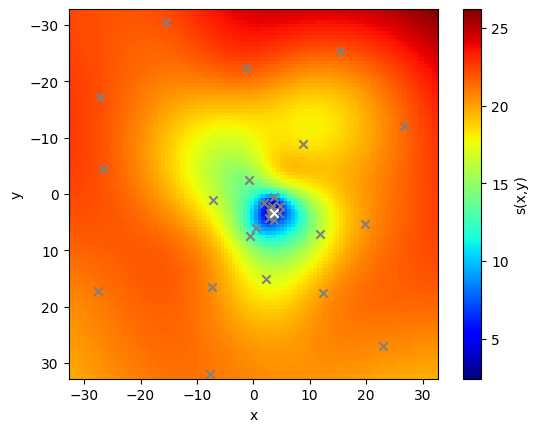

Best value of  1.7490953457131266  at  [3.34169655 3.26972961]
Last sample point at  [14.96099535 -0.66333607]
Best value of  1.7490953457131266  at  [3.34169655 3.26972961]
Last sample point at  [ 7.49039943 10.57608189]
Best value of  1.4818211016417213  at  [3.3110699  3.26138874]
Last sample point at  [3.3110699  3.26138874]
Best value of  1.4818211016417213  at  [3.3110699  3.26138874]
Last sample point at  [2.93757995 3.00316898]
Best value of  1.4818211016417213  at  [3.3110699  3.26138874]
Last sample point at  [ 8.7336584  -1.99182431]
Best value of  1.4818211016417213  at  [3.3110699  3.26138874]
Last sample point at  [-2.95944214 12.8761773 ]
Best value of  1.4818211016417213  at  [3.3110699  3.26138874]
Last sample point at  [2.67178471 2.94849321]
Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [3.14558984 3.33218503]
Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [-2.67478147  1.81721117]
Best valu

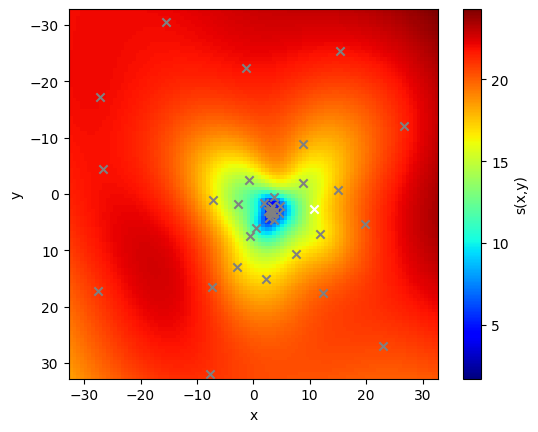

Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [3.03410015 2.92258645]
Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [3.56920346 3.35234661]
Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [3.50991252 8.76518999]
Best value of  1.2861038693621656  at  [3.14558984 3.33218503]
Last sample point at  [7.29531007 6.35730811]
Best value of  1.1715960246248014  at  [3.23018201 2.98866999]
Last sample point at  [3.23018201 2.98866999]
Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [3.16875666 3.05362413]
Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [7.20627886 1.44834096]
Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [0.12210853 3.67179463]
Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [3.27445066 2.95964881]
Best value of  0.46

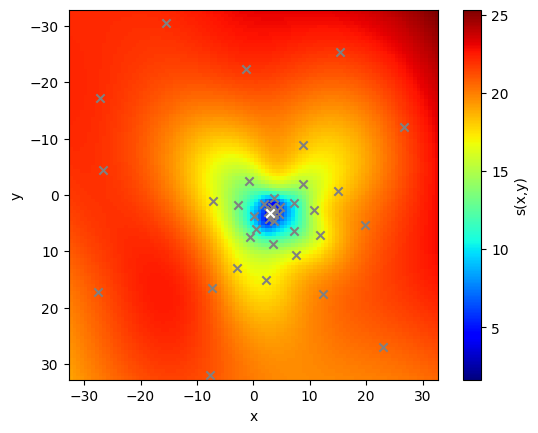

Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [ 5.88637895 -1.30597456]
Best value of  0.4647943019717826  at  [3.16875666 3.05362413]
Last sample point at  [1.49307315 3.75739438]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [3.17098707 3.1636663 ]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [3.18303601 3.17170675]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [1.34073211 5.30072824]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [4.00006017 2.14493285]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [3.08812197 3.17273324]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [3.14323776 3.32629339]
Best value of  0.150354646859157  at  [3.17098707 3.1636663 ]
Last sample point at  [2.3410901  3.66622015]
Best value of  0.1503546

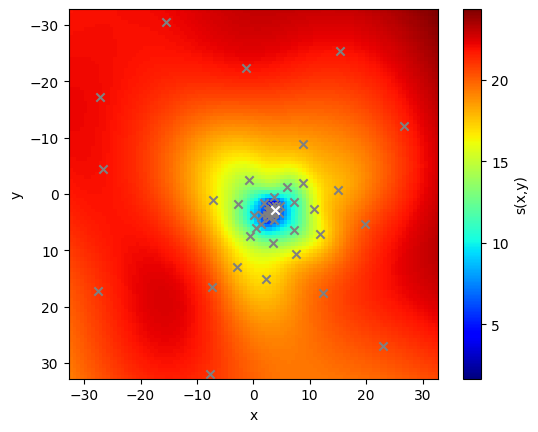

Best value of  0.029895338508346914  at  [3.1489286 3.1437569]
Last sample point at  [3.1489286 3.1437569]
Best value of  0.029895338508346914  at  [3.1489286 3.1437569]
Last sample point at  [3.11192828 3.12996224]
Best value of  0.029895338508346914  at  [3.1489286 3.1437569]
Last sample point at  [3.42428647 3.93386903]
Best value of  0.029895338508346914  at  [3.1489286 3.1437569]
Last sample point at  [4.07182971 3.88432149]
Best value of  0.029895338508346914  at  [3.1489286 3.1437569]
Last sample point at  [3.14874742 3.1448985 ]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.14517627 3.13425755]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [2.6153538  3.29480158]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [2.86418666 3.27580983]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.13297903 3.13672899]
Best value of

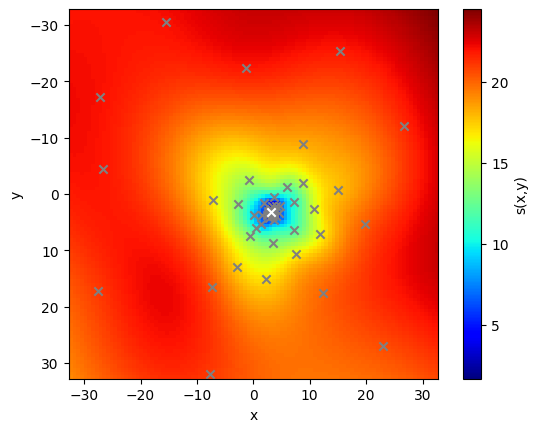

Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [2.8405234  2.69538208]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.24455826 3.09936804]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.15658444 3.13183854]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.14538219 3.10810214]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.62655887 2.99001598]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.30428    3.57973268]
Best value of  0.023457725402491025  at  [3.14517627 3.13425755]
Last sample point at  [3.12755523 3.18653383]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.14457696 3.14379739]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.4309291  3.07395987]
B

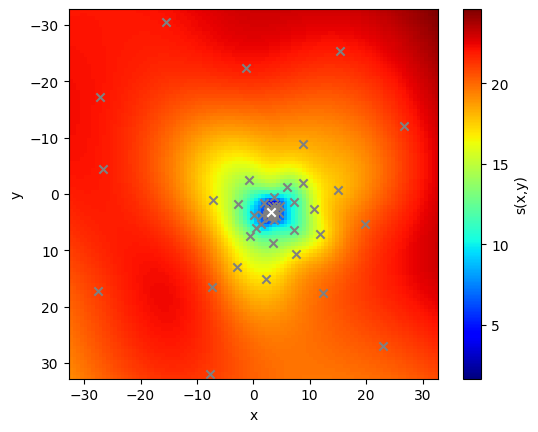

Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.13547954 3.12234895]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.14938178 3.14935869]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [2.76501118 3.60550248]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [2.99073412 3.22453068]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.14782779 3.14186252]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.13118963 3.13160795]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.55417659 2.72855396]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.18402465 2.78216462]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.19948274 3.11618071]
B

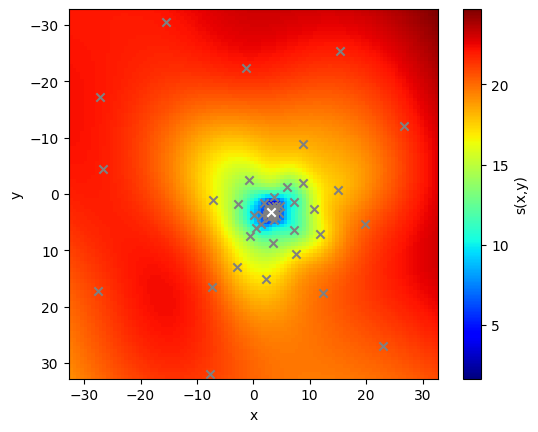

Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.21126632 3.83583951]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.11825165 3.06827404]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.10453532 3.15045263]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.11818026 3.16072479]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.38313224 2.8343938 ]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.26567102 3.18361829]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.13383983 3.13565853]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.12617858 3.14186401]
Best value of  0.017762719441130503  at  [3.14457696 3.14379739]
Last sample point at  [3.03883193 3.688909  ]
B

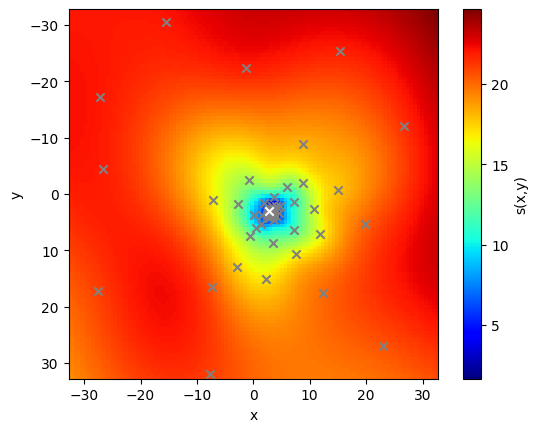

Lowest value of 0.017762719441130503 found at [3.14457696 3.14379739]


In [27]:
# method = soogo.multistart_msrs
# callback = callback_rbf

method = soogo.dycors
callback = callback_rbf

# method = soogo.surrogate_optimization
# callback = callback_rbf_muMeas

# method = soogo.cptv
# callback = callback_cptv

# method = soogo.cptvl
# callback = callback_cptv

# method = soogo.bayesian_optimization
# callback = callback_gp

# Run optimization
res = method(func, bounds=bounds, maxeval=100, callback=callback, seed=3)

# Print best point found
print(f"Lowest value of {res.fx} found at {res.x}")

Let's run a couple more times the optimization, so we can plot the average convergence curve.

In [ ]:
n_trials = 5
list_of_results = [res]
rng = np.random.default_rng(42)
for i in range(1, n_trials):
    res = method(
        func,
        bounds=bounds,
        maxeval=100,
        seed=rng.integers(np.iinfo(np.int32).max).item(),
    )
    print(f"Run #{i}: Lowest value of {res.fx} found at {res.x}")
    list_of_results.append(res)

Run #1: Lowest value of 0.01226468763821531 found at [3.13811449 3.13627799]
Run #2: Lowest value of 0.0026888723943838677 found at [3.13908602 3.1402293 ]
Run #3: Lowest value of 0.01143547616360907 found at [3.13797628 3.13666629]
Run #4: Lowest value of 0.007868454973558148 found at [3.13728765 3.13996006]


One way to see the results is to plot the average, min and max values obtained for the best solution after each function evaluation.

In [29]:
maxeval = min([len(list_of_results[i].fsample) for i in range(n_trials)])

best_y = np.full((maxeval, n_trials), np.nan)
for i in range(n_trials):  # go through all trials
    Y = list_of_results[i].fsample
    assert Y is not None

    best_y[0, i] = Y[0]
    for j in range(1, maxeval):
        if Y[j] < best_y[j - 1, i]:
            best_y[j, i] = Y[j]
        else:
            best_y[j, i] = best_y[j - 1, i]

mean_y = np.mean(best_y, axis=1)
max_y = np.max(best_y, axis=1)
min_y = np.min(best_y, axis=1)

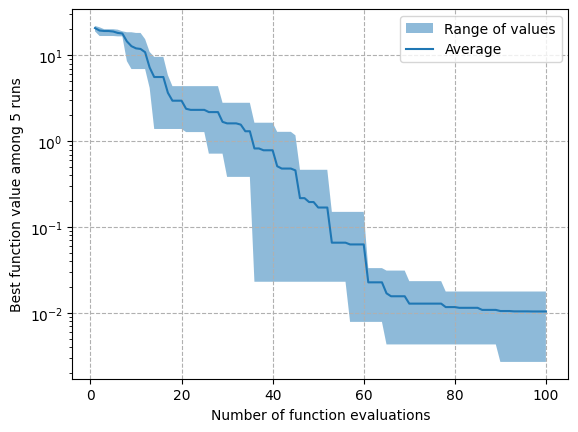

In [30]:
plt.fill_between(
    np.arange(1, maxeval + 1), min_y, max_y, alpha=0.5, label="Range of values"
)
plt.plot(np.arange(1, maxeval + 1), mean_y, label="Average")
plt.yscale("log")
plt.grid(True, linestyle="--")
plt.xlabel("Number of function evaluations")
plt.ylabel(f"Best function value among {n_trials} runs")
plt.legend()
plt.show()